In [1]:
%matplotlib inline
import numpy as np
import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [2]:
# some 3-dim points
mean = np.array([0.0,0.0,0.0])
cov = np.array([[1.0,-0.5,0.8], [-0.5,1.1,0.0], [0.8,0.0,1.0]])
data = np.random.multivariate_normal(mean, cov, 50)

In [3]:
# regular grid covering the domain of the data
X,Y = np.meshgrid(np.arange(-3.0, 3.0, 0.5), np.arange(-3.0, 3.0, 0.5))
XX = X.flatten()
YY = Y.flatten()

In [4]:
order = 2    # 1: linear, 2: quadratic
if order == 1:
    # best-fit linear plane
    A = np.c_[data[:,0], data[:,1], np.ones(data.shape[0])]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])    # coefficients
    
    # evaluate it on grid
    Z = C[0]*X + C[1]*Y + C[2]
    
    # or expressed using matrix/vector product
    #Z = np.dot(np.c_[XX, YY, np.ones(XX.shape)], C).reshape(X.shape)

elif order == 2:
    # best-fit quadratic curve
    A = np.c_[np.ones(data.shape[0]), data[:,:2], np.prod(data[:,:2], axis=1), data[:,:2]**2]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])
    # evaluate it on a grid
    Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(X.shape)
    


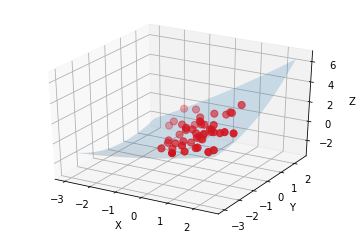

In [5]:
# plot points and fitted surface
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.2)
ax.scatter(data[:,0], data[:,1], data[:,2], c='r', s=50)
plt.xlabel('X')
plt.ylabel('Y')
ax.set_zlabel('Z')
ax.axis('equal')
ax.axis('tight')
plt.show()

In [6]:
from scipy import special
from scipy.optimize import curve_fit, leastsq

In [7]:
# Plot the results for visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [8]:
def drumhead_height(n, k, distance, angle, t):
    kth_zero = special.jn_zeros(n, k)[-1]
    return np.cos(t) * np.cos(n*angle) * special.jn(n, distance*kth_zero)


In [9]:
def gauss_2d((x,y),a,x0,s0,x1,s1):
    """
    Gaussian function 
    Parameters
    ------------
    x: np.array or float
        The independent value for a 2D Gaussian
    y: np.array or float
        The independent value for a 2D Gaussian
    a: float
        The amplitude of Gaussian
    x0: float
        The center value of the Gaussian
    sigma: float
        The one sigma width of the Gaussian
    Returns
    -------
    y:float or np.array
        The dependent value for a given independent value (x). 
    """
    return (a*np.exp(-(x-x0)**2/(2*s0**2))*np.exp(-(y-x1)**2/(2*s1**2))).ravel()

[  7.19150415e-02   1.57192428e-04   5.25209294e-01   7.91609366e-11
   5.25221008e-01]


/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':
/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Text(0.5,0,u'Z')

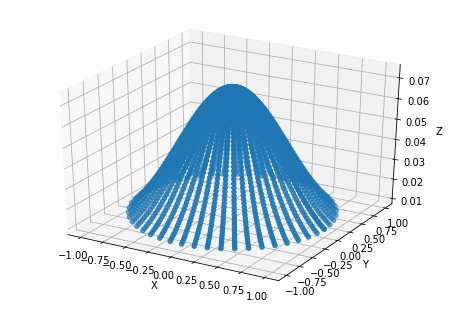

In [10]:
fig = plt.figure()
theta = np.r_[0:2*np.pi:50j]
radius = np.r_[0:1:50j]
x = np.array([r * np.cos(theta) for r in radius])
y = np.array([r * np.sin(theta) for r in radius])
z = np.array([drumhead_height(0, 1, r, theta, 1.5) for r in radius])
z1 = z+np.random.normal(loc=0.,scale=0.01,size=z.shape)


#initial guesses
p_guess = [.1,0,.1,0.,.1]
sigma = 1./np.sqrt(z.ravel())
sigma[np.isfinite(sigma) == False] = 1e30

popt, pcov = curve_fit(gauss_2d,(x.ravel(),y.ravel()),z.ravel(),p0=p_guess,sigma=sigma,maxfev=5000)
print(popt)

fig = plt.figure()
ax = Axes3D(fig)
#ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap=cm.jet)
ax.scatter(x,y,gauss_2d((x,y),*popt),zorder=1550)
#ax.scatter(x,y,z1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

In [11]:
import make_discrete_vdf as mdv
import numpy as np
import matplotlib.pyplot as plt
from fancy_plot import fancy_plot
from multiprocessing import Pool
import time
from scipy.optimize import curve_fit
import multi_fc_functions as mff
from scipy.interpolate import RectBivariateSpline
import geo_dist as gd

In [12]:
#set up plasma parameters
#                    Vx  ,  Vy,  Vz ,Wper,Wpar, Np
#pls_par = np.array([-380., -30., 30., 20., 40., 5.]) 
pls_par = np.array([-580., 10., -10., 20., 30., 15.]) 
#pls_par = np.array([-480., -100., -80., 20., 50., 25.])
#pls_par = np.array([-380., -100., 50., 30., 10., 50.]) 
#pls_par = np.array([-880., 100.,-150., 30., 10., 5.]) 
#mag_par = np.array([np.cos(np.radians(75.))*np.cos(.1), np.sin(np.radians(75.))*np.cos(.1), np.sin(.1)]) 
mag_par = np.array([-np.cos(np.radians(25.)),np.sin(np.radians(25.)), 0.]) 
#mag_par = np.array([-1.,0., 0.])

In [13]:
#Changed to mean km/s in p,q space 2018/10/19
samp = 1.5e1
#make a discrete VDF
#updated clip to a velocity width 2018/10/12 J. Prchlik
#Set to a "Total velocity width" which could be measured by the space craft 2018/10/15
vel_clip = 8.*np.sqrt(np.sum(pls_par[4:6]**2))
dis_vdf = mdv.make_discrete_vdf(pls_par,mag_par,pres=1.00,qres=1.00,clip=vel_clip)

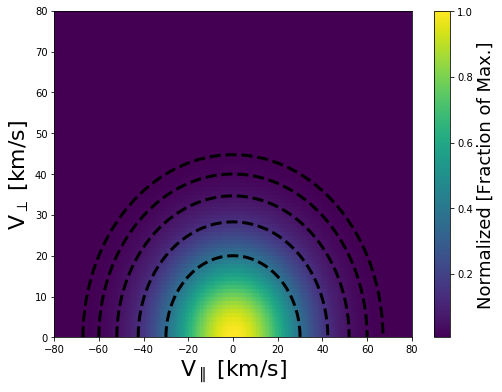

In [14]:
#"REAL" OBSERVATION
mdv.plot_vdf(dis_vdf)
plt.show()

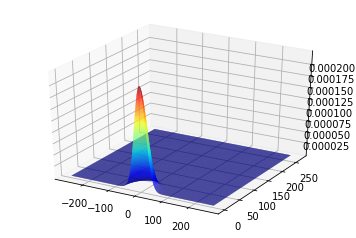

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.plot_surface(dis_vdf['pgrid'], dis_vdf['qgrid'], dis_vdf['vdf'], rstride=1, cstride=1, cmap=cm.jet)

In [16]:
def gauss_2d_vdf(vdf_test,a,x0,s0,x1,s1):
    """
    Gaussian function 
    Parameters
    ------------
    vdf_test: dictionary
        A dictiontary create by make_discrete_vdf (testing to see if I can pass a dictionary as an argument)
    a: float
        The amplitude of Gaussian
    x0: float
        The center value of the Gaussian
    sigma: float
        The one sigma width of the Gaussian
    Returns
    -------
    y:float or np.array
        The dependent value for a given independent value (x). 
    """
    x = vdf_test['pgrid'].ravel()
    y = vdf_test['qgrid'].ravel()
    return (a*np.exp(-(abs(x)-x0)**2/(2*s0**2))*np.exp(-(y-x1)**2/(2*s1**2))).ravel()

In [17]:
#initial guesses
p_guess = [.001,0,20,0.,21.]

popt, pcov = curve_fit(gauss_2d_vdf,dis_vdf,dis_vdf['vdf'].ravel(),p0=p_guess,maxfev=5000)

In [18]:
print(popt)

[  2.24483902e-04   3.34408375e-08   2.12132034e+01   7.44294315e-08
   1.41421356e+01]


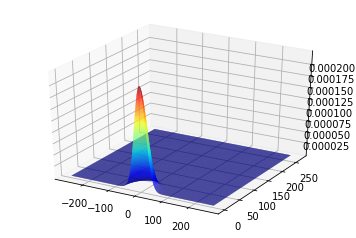

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.plot_surface(dis_vdf['pgrid'], dis_vdf['qgrid'], gauss_2d_vdf(dis_vdf,*popt).reshape(dis_vdf['pgrid'].shape), rstride=1, cstride=1, cmap=cm.jet)

In [23]:
#multi faraday cup solutions
fcs,big_arr = mff.create_multi_fc(dis_vdf,15,v_smp=40)

In [24]:
#get speed solution per observatory
v_angl = big_arr[:,0]
uv_angl = big_arr[:,5]
#thermal speed in GSE
w_angl = big_arr[:,1]
uw_angl = big_arr[:,6]
#get the density to compute the magnitude
n_angl = big_arr[:,2]
un_angl = big_arr[:,7]


#get angles from big_arr
phis   = np.radians(big_arr[:,3])
thetas = np.radians(big_arr[:,4])

#Number of processors to use when parallel processing
nproc = 8


In [25]:
#Use values with density greater than .1 and an uncertainty less than 10% 
top5 = ((un_angl/n_angl < 4.50) & (n_angl > 1e-1)) #np.sort(n_angl)[-6]
print(un_angl/n_angl)


#get v_gse solution (Produces the same solution as the Wind spacecraft solution)
#in /crater/observatories/wind/code/dvapbimax/sub_bimax_moments.pro
v_vec =  mdv.compute_gse_from_fit(phis[top5],thetas[top5],-v_angl[top5]) #np.dot(np.dot(np.dot(v_svdc.T,wp_svdc),u_svdc.T),v_angl)
vx,vy,vz = v_vec


[  2.07589132e-03   6.97128164e-05   6.19729537e-05   4.58297712e-02
   6.02501642e-05   8.23959644e-05   1.42016319e+06   6.30540584e-03
   1.41578688e+01   1.44598898e-02   1.44506023e+01   7.85755333e+04
   5.68888313e+06   3.05795571e-03   1.43077219e+01]


In [26]:
#Get Wper and Wpar vectors using maximum and minimum values
wv_par =  mdv.compute_gse_from_fit(np.radians(phis[top5]),np.radians(thetas[top5]),w_angl[top5])
wa = np.max(w_angl[top5])
we = np.min(w_angl[top5])


In [27]:
#compute angle between FC and the observed bulk velocity (cos(theta`))
n = np.median(np.abs(n_angl[top5]))

In [110]:
if we < 0.9*np.min(w_angl[top5]):
    we = np.min(w_angl[top5])
elif we > 1.1*np.max(w_angl[top5]):
    we = np.max(w_angl[top5])

if wa < 0.9*np.min(w_angl[top5]):
    wa = np.min(w_angl[top5])
elif wa > 1.1*np.max(w_angl[top5]):
    wa = np.max(w_angl[top5])

#make a discrete VDF with the incorrect parameters but the same grid
pls_par_bad = np.array([vx, vy, vz,we,wa,n])


In [98]:
#######Give info on best fit versus real solution######
print(pls_par)
print(pls_par_bad)

[-580.   10.  -10.   20.   30.   15.]
[-582.58102355   37.8354871   -10.45949606   21.27543484   28.82284274
   13.17374034]


In [99]:

######################################################################
######################################################################
#EVERYTHING BEFORE THIS WOULD BE MEASURED BY A SPACECRAFT
######################################################################
######################################################################

#Updated with vel_clip parameter 2108/10/12 J. Prchlik
dis_vdf_bad = mdv.make_discrete_vdf(pls_par_bad,mag_par,pres=1.00,qres=1.00,clip=vel_clip)
#store the initial bad guess 
dis_vdf_bad_guess = dis_vdf_bad
dis_vdf_bad = dis_vdf_bad_guess

In [31]:
from multiprocessing import Pool

In [107]:
def gauss_2d_reconstruct(z,fcs,cur_vdf):
    """
    Gaussian function 
    Parameters
    ------------
    z: list
        A list of 
    fcs: dictionary
        A dictionary of Faraday cups created by mff.create_multi_fc()
    cur_vdf: dictionary
        Dictionary of the velocity distribution created by make_discrete_vdf()
        
    Returns
    -------
    y:float or np.array
        The measured current of all Faraday Cups
    """
    vx = cur_vdf['u_gse'][0]
    vy = cur_vdf['u_gse'][1]
    vz = cur_vdf['u_gse'][2]
    
    vx,vy,vz,wper, wpar, den = z
    
    #                   Vx,Vy,Vz,Wper,Wpar, Np
    pls_par = np.array([vx,vy,vz,wper, wpar, den]) 
    
    #Get static variables from cur_vdf to add to creation of new guess VDF
    vel_clip = cur_vdf['pgrid'].max()
    pres     = np.mean(np.diff(cur_vdf['pgrid'][:,0]))
    qres     = np.mean(np.diff(cur_vdf['qgrid'][0,:]))
    
    #Create new VDF guess based on input parameters
    dis_vdf = mdv.make_discrete_vdf(pls_par,cur_vdf['b_gse'],pres=pres,qres=qres,clip=vel_clip) 
    
    looper = []
    #loop over all fc in fcs to populate with new VDF guess
    for i,key in enumerate(fcs.keys()):
        #add variation and store which faraday cup you are working with using key
        #Updated with varying integration sampling function 2018/10/12 J. Prchlik
        inpt_x = fcs[key]['x_meas'].copy()
        g_vdf  = dis_vdf.copy()
        peak   =  fcs[key]['peak'].copy()
        looper.append((inpt_x,g_vdf,samp,key))
        
    #process in parallel
    nproc = 8
    pool = Pool(processes=nproc)
    dis_cur = pool.map(mff.proc_wrap,looper)
    pool.close()
    pool.join()       
    
    
    #break into index value in looper and the 1D current distribution
    index   = np.array(zip(*dis_cur)[1])
    dis_cur = np.array(zip(*dis_cur)[0])


    #get sum squared best fit
    tot_err = np.zeros(dis_cur.shape[0])
    tot_int = np.zeros(dis_cur.shape[0])
    #Get error in each faraday cup
    for j,i in enumerate(index):
        tot_err[j] = np.sum((dis_cur[j,:] - fcs[i]['rea_cur'])**2)
        tot_int[j] = np.sum((fcs[i]['rea_cur'])**2)

    #print(tot_err)
    #total error for all fc
    tot_err[tot_int < 1e-25] = 0
    #fcs_err = np.median(tot_err)
    fcs_err = np.sum(tot_err**2) /np.sum(tot_int**2)
    #Remove really bad values from guess fitting

    print(pls_par,fcs_err)
        
    return fcs_err

In [108]:
from scipy import optimize

In [111]:
print(gauss_2d_reconstruct(pls_par_bad,fcs,dis_vdf_bad))
print(gauss_2d_reconstruct(pls_par,fcs,dis_vdf))

(array([-582.58102355,   37.8354871 ,  -10.45949606,   21.27543484,
         28.82284274,   13.17374034]), 0.0062437048557693548)
0.00624370485577
(array([-580.,   10.,  -10.,   20.,   30.,   15.]), 1.0642788098761482e-37)
1.06427880988e-37


In [45]:
#initial guesses Wper,Wpar,Np 
###p_guess = pls_par_bad[3:]
###rranges=(slice(10,30,10),slice(10,30,10),slice(10,30,10)) 
###
###brute = optimize.brute(gauss_2d_reconstruct,rranges, args=(fcs,dis_vdf_bad),full_output=False,finish=optimize.fmin_powell)

(array([-582.58102355,   37.8354871 ,  -10.45949606,   10.        ,
         10.        ,   10.        ]), 2.5532353980544518e-18)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   10.        ,
         10.        ,   10.        ]), 2.5532353980544518e-18)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   10.        ,
         10.        ,   20.        ]), 1.2366775759836307e-17)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   10.        ,
         20.        ,   10.        ]), 9.1443869899132969e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   10.        ,
         20.        ,   20.        ]), 3.621671786772866e-18)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   20.        ,
         10.        ,   10.        ]), 1.4398478463813944e-18)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   20.        ,
         10.        ,   20.        ]), 7.4906288087917173e-18)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   20.        ,
         20.    

(array([-582.58102355,   37.8354871 ,  -10.45949606,   36.79038934,
         21.0472821 ,   13.88304606]), 3.9602634453000591e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   36.72414785,
         21.0472821 ,   13.88304606]), 3.9602758748420698e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   36.85663083,
         21.0472821 ,   13.88304606]), 3.9602958578149692e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   36.79038934,
         21.0472821 ,   13.88304606]), 3.9602634453000591e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   36.79038934,
         22.0472821 ,   13.88304606]), 3.869657249714711e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   36.79038934,
         23.6653161 ,   13.88304606]), 3.7772679653155802e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   36.79038934,
         25.08704687,   13.88304606]), 3.7423130633990886e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   36.79038934,
         27.3874

(array([-582.58102355,   37.8354871 ,  -10.45949606,   30.93190679,
         29.57100384,   14.66502614]), 3.5262982186327723e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   30.90568051,
         29.58567387,   14.66651374]), 3.5262953797525996e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   33.79973384,
         29.88380674,   15.77191184]), 3.6158429583204447e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   26.22300382,
         29.10328476,   12.87794203]), 3.9195995427236809e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   30.90568051,
         29.58567387,   14.66651374]), 3.5262953797525996e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   29.11705722,
         29.40141763,   13.98334016]), 3.5820255088439926e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   32.01111049,
         29.69955049,   15.08873823]), 3.53633592793652e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   31.13178254,
         29.60896

In [47]:
###print(brute)
###print(p_guess)
###print(pls_par[3:])

[ 31.07901647  29.77105172  14.7432968 ]
[ 21.27543484  28.82284274  13.17374034]
[ 20.  30.  15.]


In [48]:
import time

4.50611114502e-05


In [151]:
print(f3(resbrute,*params))

-1.39125074198e-15


In [ ]:
#try actually using an initial guess instead of brute force
#NEED TO INCLUDE VELOCITY IN PARAMETER ESTIMATION OTHERWISE WILL TRY TO ACCOUNT FOR
#INCORRECT Vx,Vy,Vz values with LARGER VELOCITY WIDTHS
p_guess = pls_par_bad
#p_guess = [ 21.27543484,  28.82284274, 13.17374034]
x1 = time.time()
powell = optimize.minimize(gauss_2d_reconstruct,p_guess, args=(fcs,dis_vdf_bad),method='Powell',options={'maxiter':10})
x2 = time.time()
print(x2-x1)

(array([-582.58102355,   37.8354871 ,  -10.45949606,   21.27543484,
         28.82284274,   13.17374034]), 0.0062437048557693548)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   21.27543484,
         28.82284274,   13.17374034]), 0.0062437048557693548)
(array([-581.58102355,   37.8354871 ,  -10.45949606,   21.27543484,
         28.82284274,   13.17374034]), 0.0067848329980099821)
(array([-584.19905755,   37.8354871 ,  -10.45949606,   21.27543484,
         28.82284274,   13.17374034]), 0.0060025725834870654)
(array([-583.8875667 ,   37.8354871 ,  -10.45949606,   21.27543484,
         28.82284274,   13.17374034]), 0.0059776769386242238)
(array([-583.8875667 ,   37.8354871 ,  -10.45949606,   21.27543484,
         28.82284274,   13.17374034]), 0.0059776769386242238)
(array([-583.38851164,   37.8354871 ,  -10.45949606,   21.27543484,
         28.82284274,   13.17374034]), 0.0060128602873348565)
(array([-583.69694464,   37.8354871 ,  -10.45949606,   21.27543484,
         28.82284274, 

(array([-585.08977624,  -11.22504806,   -5.29301439,   17.33077755,
         26.60435258,   15.34280472]), 0.016330836988803166)
(array([-583.83539989,   13.30521952,   -7.87625523,   19.30310619,
         27.71359766,   14.25827253]), 0.00036181292142658839)
(array([-582.83539989,   13.30521952,   -7.87625523,   19.30310619,
         27.71359766,   14.25827253]), 0.00013268712751316261)
(array([-581.21736589,   13.30521952,   -7.87625523,   19.30310619,
         27.71359766,   14.25827253]), 2.3146026524240325e-05)
(array([-581.47739579,   13.30521952,   -7.87625523,   19.30310619,
         27.71359766,   14.25827253]), 2.8771361409439532e-05)
(array([-578.59933187,   13.30521952,   -7.87625523,   19.30310619,
         27.71359766,   14.25827253]), 0.00010081991138370951)
(array([-581.21736589,   13.30521952,   -7.87625523,   19.30310619,
         27.71359766,   14.25827253]), 2.3146026524240325e-05)
(array([-580.21736591,   13.30521952,   -7.87625523,   19.30310619,
         27.71359

(array([-580.75998084,   10.05885517,   -9.37777035,   21.42398071,
         28.47199921,   14.7272146 ]), 1.7026622439949638e-06)
(array([-580.75998084,   10.05885517,   -9.37777035,   21.42398071,
         28.47199921,   14.73473433]), 1.7017722763271883e-06)
(array([-580.75998084,   10.05885517,   -9.37777035,   21.42398071,
         28.47199921,   14.73949895]), 1.7019559553526335e-06)
(array([-577.68456179,    6.81249083,  -10.87928547,   23.54485522,
         29.23040076,   15.21119613]), 4.4551760601517649e-05)
(array([-580.75998084,   10.05885517,   -9.37777035,   21.42398071,
         28.47199921,   14.73473433]), 1.7017722763271883e-06)
(array([-577.68456179,    6.81249083,  -10.87928547,   23.54485522,
         29.23040076,   15.21119613]), 4.4551760601517649e-05)
(array([-585.73611343,   15.31158306,   -6.94826783,   17.99233364,
         27.24487972,   13.96380294]), 0.0017663779448971338)
(array([-580.75998084,   10.05885517,   -9.37777035,   21.42398071,
         28.4719

In [51]:
####x1 = time.time()
####bfgs = optimize.minimize(gauss_2d_reconstruct,p_guess, args=(fcs,dis_vdf_bad),method='BFGS')
####x2 = time.time()
####print(x2-x1)

(array([-582.58102355,   37.8354871 ,  -10.45949606,   21.27543484,
         28.82284274,   13.17374034]), 4.0824896514116363e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   21.27543486,
         28.82284274,   13.17374034]), 4.0824896498918787e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   21.27543484,
         28.82284276,   13.17374034]), 4.0824896511181448e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   21.27543484,
         28.82284274,   13.17374036]), 4.0824896492963474e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   21.27543484,
         28.82284274,   13.17374034]), 4.0824896514116363e-19)


In [53]:
####x1 = time.time()
####newton = optimize.minimize(gauss_2d_reconstruct,p_guess, args=(fcs,dis_vdf_bad),method='Nelder-Mead')
####x2 = time.time()
####print(x2-x1)

(array([-582.58102355,   37.8354871 ,  -10.45949606,   21.27543484,
         28.82284274,   13.17374034]), 4.0824896514116363e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   22.33920658,
         28.82284274,   13.17374034]), 3.9846674484500641e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   21.27543484,
         30.26398488,   13.17374034]), 4.0814107953712142e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   21.27543484,
         28.82284274,   13.83242736]), 4.0620059830368364e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   21.984616  ,
         29.78360417,   13.61286502]), 3.9501001367326203e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   22.33920658,
         30.26398488,   13.83242736]), 3.8984934316088241e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   22.69379716,
         28.34246203,   14.0519897 ]), 3.9425357339142396e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   23.63937204,
         29.463

(array([-582.58102355,   37.8354871 ,  -10.45949606,   31.11784323,
         29.7911073 ,   14.75159948]), 3.5255100442219736e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   31.16218878,
         29.78354627,   14.76624062]), 3.5254962925719091e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   31.20677311,
         29.75577845,   14.76912701]), 3.5255222632053029e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   31.14692934,
         29.82648019,   14.78486976]), 3.5255138888228529e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   31.12511476,
         29.79995052,   14.75991705]), 3.5254949663511719e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   31.1809635 ,
         29.77313744,   14.74906541]), 3.5255409982009109e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   31.12048939,
         29.81327204,   14.76957319]), 3.5254910804876355e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   31.13722321,
         29.781

(array([-582.58102355,   37.8354871 ,  -10.45949606,   31.12641186,
         29.80560911,   14.76701645]), 3.525490328006948e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   31.12637808,
         29.80541342,   14.76697946]), 3.5254903278384609e-19)
515.124267101


In [101]:
#Initial guess around current guess of 2d VDF
pls_par_bad = np.array([-582.58102355,   37.8354871 ,  -10.45949606,   31.12637808, 29.80541342,   14.76697946])
dis_vdf_bad_guess = mdv.make_discrete_vdf(pls_par_bad,mag_par,pres=1.00,qres=1.00,clip=vel_clip)
pred_grid = dis_vdf_bad_guess['vdf'].copy()
default_grid = pred_grid.copy()
good_vdf_values =  np.isfinite(pred_grid)
pred_grid[good_vdf_values == False] = np.min(pred_grid[good_vdf_values])
pred_grid -= np.min(pred_grid)
pred_grid /= np.sum(pred_grid)

#Get the initial distribution based on input parameters 2018/09/19 J. Prchlik 
for k,i in enumerate(fcs.keys()):
    i = 'fc_{0:1d}'.format(k)
    #updated using dynamic sampling 2018/10/12 J. Prchlik
    fcs[i]['init_guess'] = mdv.arb_p_response(fcs[i]['x_meas'],dis_vdf_bad,samp)

#Run MC so I can create a plot comparing observations
iters = 1
kernel = 500
fcs,dis_vdf_bad,pred_grid,kernel,improved,ip,iq,n_p_prob,counter,per_err_list,ker_sze_list = mff.mc_reconstruct(fcs,nproc,dis_vdf_bad,
                                                                             pred_grid,kernel,iters,verbose=False,
                                                                             default_grid=default_grid,counter=0,
                                                                             return_convergence=True,min_kernel=15,tol_cnt=300)


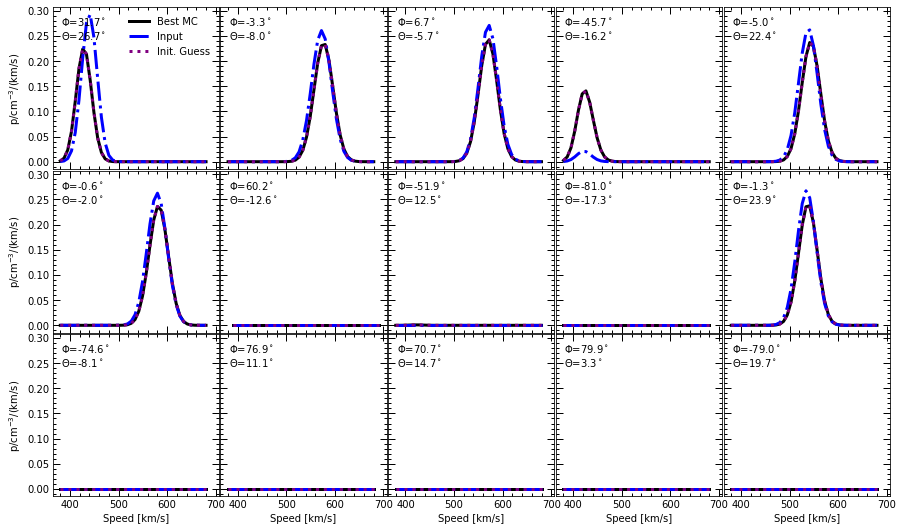

In [102]:
mff.create_fc_grid_plot(fcs)
plt.show()